In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from extract_transform import get_match

In [19]:
def get_chain_restaurant_qids(chain_restaurant_wikidata):
    """Get a dictionary which maps chain restaurant qids to 1
    
    Args:
        chain_restaurant_wikidata (dataframe):
            Wikidata for chain restaurants 
        
    Returns:
        chain_restaurant_qids (dict):
            contains (qid, 1) key value pairs for qids associated
            with chain restaurants
    """
    
    num_chain_restaurant_qids = chain_restaurant_wikidata.shape[0]
    chain_restaurant_qids = dict(zip(
        chain_restaurant_wikidata['qid'], 
        np.ones(num_chain_restaurant_qids, dtype=int)
    ))
    return chain_restaurant_qids
    
def get_num_chain_restaurants(osm_data, chain_restaurant_qids):
    """Get the (estimated) number of chain restaurants from the OSM data
    using chain restaurant qids
    
    Args:
        osm_data (dataframe):
            OSM data preprocessed using preprocess_osm_data.py
        
    Returns:
        num_chain_restaurants (int):
            the number of chain restaurants within the OSM data
    """
    
    num_chain_restaurants = osm_data['qid'].map(chain_restaurant_qids).sum()
    num_chain_restaurants = int(num_chain_restaurants)
    return num_chain_restaurants

def display_num_chain_qid_restaurants(chain_restaurant_qids, num_chain_restaurants):
    """Print the number of chain restaurant qids and chain restaurants
    within the OSM data
    
    Args:
        chain_restaurant_qids (dict):
            contains (qid, 1) key value pairs for qids related to 
            chain restaurants
            
        num_chain_restaurants (int):
            the number of chain restaurants within the OSM data
    
    Returns:
        None
    """
    num_chain_restaurant_qids = len(chain_restaurant_qids)
    print('Number of Wikidata Entries about Chain Restaurants: ', end='')
    print(num_chain_restaurant_qids)
    print(f'Number of Chain Restaurants: {num_chain_restaurants}')
    
# TODO - add docstrings, maybe move functions to modules
def llf(leaf_id): # leaf label func for dendrogram adapted from scipy docs
    """Map leaf_id (index) to Wikidata name
    
    Args:
        leaf_id (int):
    
    Returns:
        leaf_name (str):
    """
    
    leaf_name = wikidata.loc[leaf_id, 'name']
    return leaf_name

# map names to red if their wikidata description contains 'chain' and 'restaurant'
def get_color(ylabel): 
    try:
        color = color_dict[ylabel.get_text()]
    except:
        color = 'blue'
    return color

In [4]:
osm_data = pd.read_json('data/preprocessed-osm-data.json.gz')

raw_wikidata = pd.read_json('data/wikidata.json')
preprocessed_wikidata = pd.read_json('data/preprocessed-wikidata.json')
wikidata = raw_wikidata.merge(preprocessed_wikidata, on='qid')

wikidata['name'] = wikidata['names'].apply(lambda names: names[0])
descriptions = wikidata['preprocessed_description']

The aim of this notebook is to identify chain restaurants by determining which Wikidata entries are about chain restaurants and mapping the results back to the OSM data.

In [5]:
contains_chain = wikidata['preprocessed_description'].apply(
    lambda description: get_match('chain', description)
).notna()

contains_restaurant = wikidata['preprocessed_description'].apply(
    lambda description: get_match('restaurant', description)
).notna()
contains_chain_and_restaurant = (contains_chain & contains_restaurant)

chain_restaurant_wikidata = wikidata[contains_chain_and_restaurant]

First, we start off with a regex approach which assumes that a Wikidata entry is about a chain restaurant if its description contains both the words 'chain' and 'restaurant'. 

We check for both 'chain' and 'restaurant' based on how checking for 'chain' alone can potentially result in more false positives since it can also describe non-restaurants.

In [18]:
# include entries that contain the words 'chain' and 'restaurant'
chain_restaurant_wikidata = wikidata[contains_chain_and_restaurant]
chain_restaurant_qids = get_chain_restaurant_qids(chain_restaurant_wikidata)

# map back to OSM data to get the number of chain restaurants
num_chain_restaurants = get_num_chain_restaurants(osm_data, chain_restaurant_qids)

display_num_chain_qid_restaurants(chain_restaurant_qids, num_chain_restaurants)

Number of Wikidata Entries about Chain Restaurants: 38
Number of Chain Restaurants: 691


The regex approach considers 38 Wikidata entries to be about chain restaurants and 691 OSM locations to be chain restaurants. Limitations of the regex approach include how it may result in false negatives and underestimate the number of chain restaurants due to how descriptions for some chain restaurants may not contain both the words 'chain' and 'restaurant'.

Based on these limitations we move on to a mixed approach which uses the regex results in addition to clustering with cosine similarity.

In [9]:
# calculate cosine similarities between each Wikidata description
vectorizer = CountVectorizer(lowercase=False)
document_term_matrix = vectorizer.fit_transform(descriptions)
cosine_similarities = cosine_similarity(document_term_matrix)

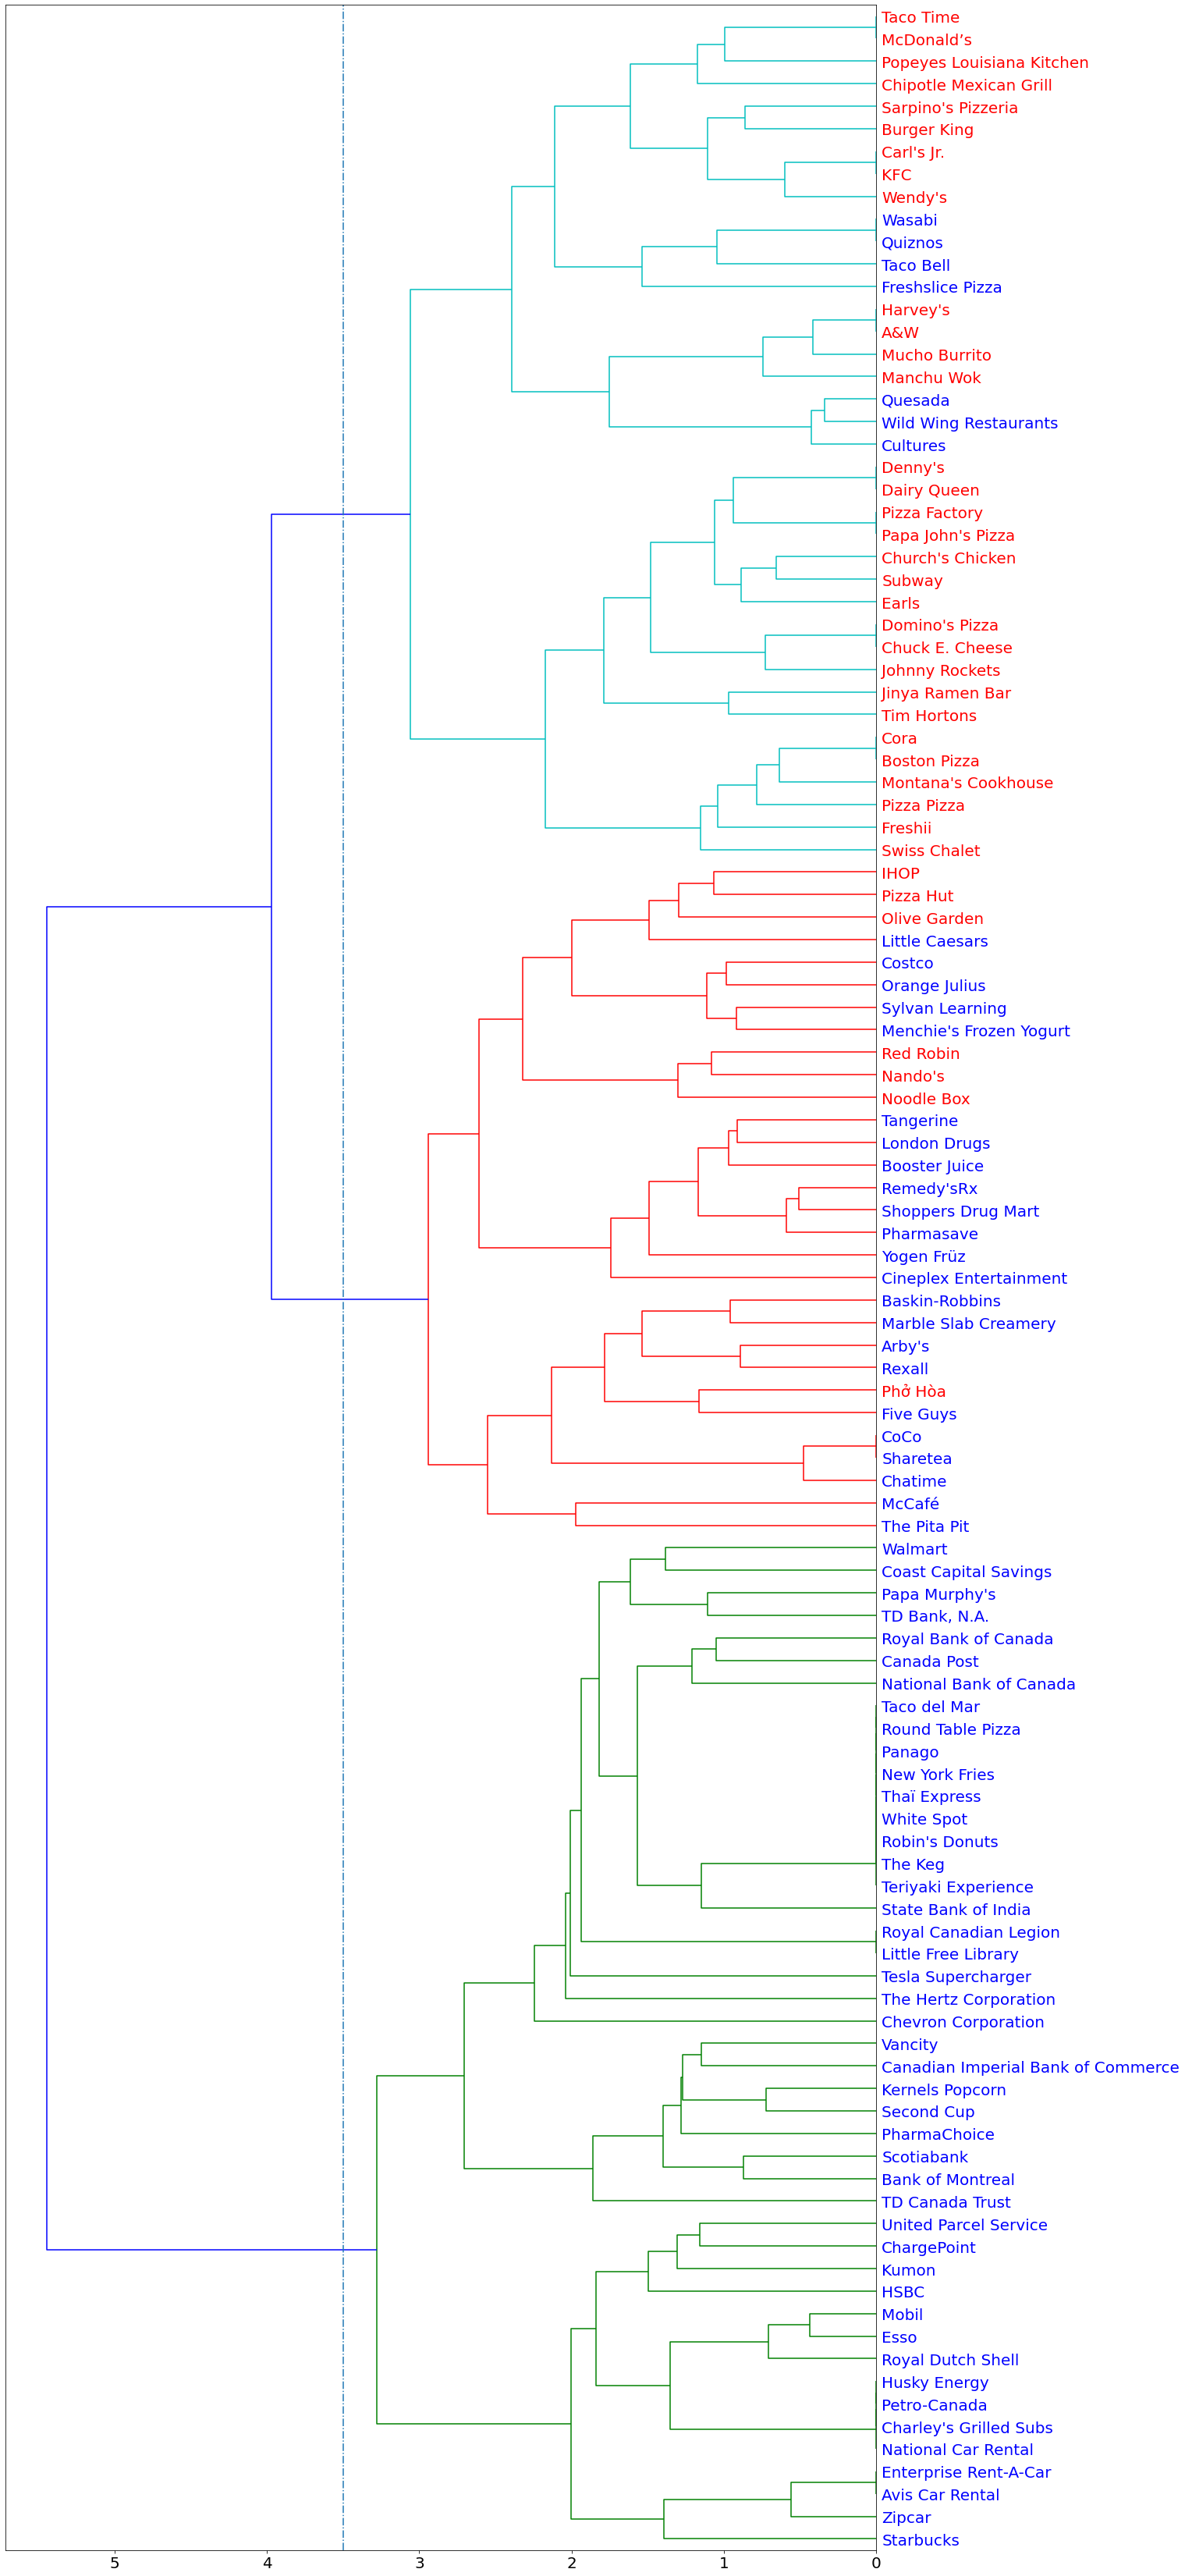

In [10]:
# get names of chain restaurants that will later be used for dendrogram labels 
chain_restaurant_names = chain_restaurant_wikidata['name'].values
# color names associated with wikidata descriptions that contain 'chain' and 'restaurant' red
# -> compare regex predictions with cosine similarity clusters
color_dict = {}
for name in chain_restaurant_names:
    color_dict[name] = 'r'
    
# scipy dendrogram docs
Z = linkage(cosine_similarities, method='complete')

# LOOKS UGLY ON GITLAB USE https://kokes.github.io/nbviewer.js/viewer.html
fig = plt.figure(figsize=(20, 60)) 
dn = dendrogram(Z, leaf_label_func=llf, orientation='left', leaf_font_size=20) 

# label coloring adapted from Warren Weckesser's answer at 
# https://stackoverflow.com/questions/14802048/
ax = plt.gca()
ylabels = ax.get_ymajorticklabels()
for ylabel in ylabels:
    ylabel.set_color(get_color(ylabel))
plt.xticks(size=20)
plt.yticks(size=20)

plt.axvline(x=3.5, linestyle='-.')
plt.show()

In [12]:
names = llf(wikidata.index) # get names given index 
clusters = fcluster(Z, t=3, criterion='maxclust')

In [13]:
# create dataframe containing columns for name and cluster
name_cluster = pd.DataFrame.from_dict(
    dict(zip(names, clusters)), 
    orient='index'
).reset_index().rename(columns={'index': 'name', 0:'cluster'})

In [14]:
# find the cluster with the most chain restaurants 
chain_restaurant_wikidata = chain_restaurant_wikidata.merge(name_cluster, on='name')
chain_restaurant_cluster = chain_restaurant_wikidata['cluster'].value_counts().idxmax()

In [15]:
is_within_chain_restaurant_cluster = (name_cluster['cluster'] == chain_restaurant_cluster)
is_chain_restaurant = (contains_chain_and_restaurant | is_within_chain_restaurant_cluster)

In [17]:
# include entries within the cluster with the most chain restaurants 
updated_chain_restaurant_wikidata = wikidata[is_chain_restaurant]
updated_chain_restaurant_qids = get_chain_restaurant_qids(updated_chain_restaurant_wikidata)

# map back to OSM data to get the updated number of chain restaurants
updated_num_chain_restaurants = get_num_chain_restaurants(osm_data, updated_chain_restaurant_qids)

display_num_chain_qid_restaurants(updated_chain_restaurant_qids, updated_num_chain_restaurants)

Number of Wikidata Entries about Chain Restaurants: 45
Number of Chain Restaurants: 746


In [ ]:
# write updated_chain_restaurant_qids to json

cluster correctly groups some chain restaurants with descriptions that do not contain the words
'chain' or 'restaurant'